# API Fundamentals - Advanced Retry Strategies

This notebook focuses on two critical production-grade techniques for handling API failures:

1. **Exponential Backoff with Jitter** - Prevents retry storms
2. **Circuit Breaker Pattern** - Fails fast during outages

We'll use OpenAI API as our example throughout.

## Learning Goals

After this lesson, you will be able to:

- [ ] Implement exponential backoff with jitter to prevent retry storms
- [ ] Build a circuit breaker to handle API outages gracefully
- [ ] Combine both patterns for production-ready error handling
- [ ] Apply these techniques to OpenAI API calls

## Setup

First, let's import the necessary libraries and set up our OpenAI client.

In [1]:
import os
import time
import random
from openai import OpenAI
from typing import Optional, Callable, Any
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Default model
MODEL = "gpt-4o-mini"

print("✅ Setup complete!")

✅ Setup complete!


---

## 1. Exponential Backoff with Jitter

### The Problem: Retry Storms

When multiple clients all fail at the same time (e.g., during an API outage), they all retry at the same intervals:

- All retry after 1 second → API gets hammered again
- All retry after 2 seconds → API gets hammered again
- All retry after 4 seconds → API gets hammered again

This is called a **"retry storm"** and makes the problem worse!

### The Solution: Add Randomness (Jitter)

Jitter spreads out retry attempts so they don't all happen at once.

### Basic Exponential Backoff (Without Jitter)

Let's first see what happens without jitter:

In [2]:
def exponential_backoff_no_jitter(attempt, base_delay=1, max_delay=60):
    """Calculate backoff time WITHOUT jitter."""
    delay = base_delay * (2 ** attempt)
    delay = min(delay, max_delay)
    return delay

# Simulate multiple clients retrying
print("Without jitter (all clients retry at same time):")
print("-" * 50)
for attempt in range(5):
    delay = exponential_backoff_no_jitter(attempt)
    print(f"Attempt {attempt}: All clients wait {delay} seconds → All retry together!")
    print(f"  ⚠️  Problem: Retry storm at {delay}s mark")

Without jitter (all clients retry at same time):
--------------------------------------------------
Attempt 0: All clients wait 1 seconds → All retry together!
  ⚠️  Problem: Retry storm at 1s mark
Attempt 1: All clients wait 2 seconds → All retry together!
  ⚠️  Problem: Retry storm at 2s mark
Attempt 2: All clients wait 4 seconds → All retry together!
  ⚠️  Problem: Retry storm at 4s mark
Attempt 3: All clients wait 8 seconds → All retry together!
  ⚠️  Problem: Retry storm at 8s mark
Attempt 4: All clients wait 16 seconds → All retry together!
  ⚠️  Problem: Retry storm at 16s mark


### Exponential Backoff WITH Jitter

Now let's add jitter to spread out the retries:

In [3]:
def exponential_backoff_with_jitter(attempt, base_delay=1, max_delay=60):
    """
    Calculate backoff time with jitter.
    
    Args:
        attempt: Current retry attempt (0-indexed)
        base_delay: Base delay in seconds
        max_delay: Maximum delay in seconds
    
    Returns:
        Wait time in seconds with jitter applied
    """
    # Calculate exponential delay: base_delay * (2 ^ attempt)
    delay = base_delay * (2 ** attempt)
    
    # Cap at max_delay
    delay = min(delay, max_delay)
    
    # Add jitter: random value between 0 and delay
    # This spreads out retries so they don't all happen at once
    jittered_delay = delay * random.random()
    
    return jittered_delay

# Simulate multiple clients retrying with jitter
print("With jitter (clients retry at different times):")
print("-" * 50)
for attempt in range(5):
    # Simulate 3 clients retrying
    delays = [exponential_backoff_with_jitter(attempt) for _ in range(3)]
    print(f"Attempt {attempt}: Clients wait {[f'{d:.2f}' for d in delays]} seconds")
    print(f"  ✅ Retries spread out - no storm!")

With jitter (clients retry at different times):
--------------------------------------------------
Attempt 0: Clients wait ['0.68', '0.62', '0.30'] seconds
  ✅ Retries spread out - no storm!
Attempt 1: Clients wait ['1.52', '1.22', '0.90'] seconds
  ✅ Retries spread out - no storm!
Attempt 2: Clients wait ['3.07', '1.58', '1.21'] seconds
  ✅ Retries spread out - no storm!
Attempt 3: Clients wait ['4.88', '5.55', '5.50'] seconds
  ✅ Retries spread out - no storm!
Attempt 4: Clients wait ['8.31', '1.07', '2.03'] seconds
  ✅ Retries spread out - no storm!


### Visual Comparison

Let's visualize the difference:

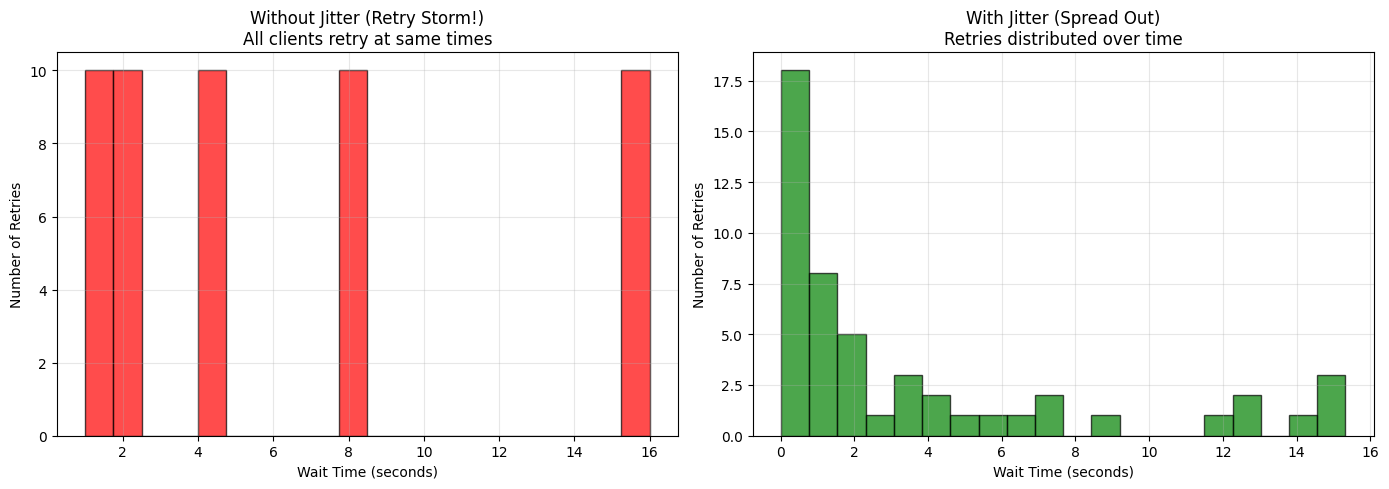


💡 Notice how jitter spreads out the retries, preventing storms!


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate 10 clients retrying
attempts = list(range(5))
num_clients = 10

# Without jitter
no_jitter_times = []
for attempt in attempts:
    delay = exponential_backoff_no_jitter(attempt)
    no_jitter_times.extend([delay] * num_clients)

# With jitter
jitter_times = []
for attempt in attempts:
    delays = [exponential_backoff_with_jitter(attempt) for _ in range(num_clients)]
    jitter_times.extend(delays)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Without jitter
ax1.hist(no_jitter_times, bins=20, edgecolor='black', alpha=0.7, color='red')
ax1.set_title('Without Jitter (Retry Storm!)\nAll clients retry at same times', fontsize=12)
ax1.set_xlabel('Wait Time (seconds)')
ax1.set_ylabel('Number of Retries')
ax1.grid(True, alpha=0.3)

# With jitter
ax2.hist(jitter_times, bins=20, edgecolor='black', alpha=0.7, color='green')
ax2.set_title('With Jitter (Spread Out)\nRetries distributed over time', fontsize=12)
ax2.set_xlabel('Wait Time (seconds)')
ax2.set_ylabel('Number of Retries')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Notice how jitter spreads out the retries, preventing storms!")

### Implementing Jittered Retry with OpenAI

Now let's create a practical wrapper for OpenAI API calls with jittered retry:

In [5]:
def call_openai_with_jittered_retry(
    prompt: str,
    max_retries: int = 3,
    base_delay: float = 1.0,
    max_delay: float = 60.0
) -> str:
    """
    Call OpenAI API with exponential backoff and jitter.
    
    Args:
        prompt: The prompt to send to OpenAI
        max_retries: Maximum number of retry attempts
        base_delay: Base delay for exponential backoff
        max_delay: Maximum delay between retries
    
    Returns:
        The response content from OpenAI
    """
    for attempt in range(max_retries + 1):
        try:
            response = client.chat.completions.create(
                model=MODEL,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.choices[0].message.content
        
        except Exception as e:
            if attempt == max_retries:
                print(f"❌ Failed after {max_retries} retries: {e}")
                raise
            
            # Calculate wait time with jitter
            wait_time = exponential_backoff_with_jitter(attempt, base_delay, max_delay)
            
            print(f"⚠️  Attempt {attempt + 1} failed: {type(e).__name__}")
            print(f"   Retrying in {wait_time:.2f} seconds...")
            
            time.sleep(wait_time)

print("✅ Jittered retry function ready!")

✅ Jittered retry function ready!


### Testing the Jittered Retry

Let's test it with a real OpenAI call:

In [6]:
# Test with a simple prompt
prompt = "Say hello in one sentence."

try:
    response = call_openai_with_jittered_retry(prompt, max_retries=3)
    print(f"\n✅ Success!")
    print(f"Response: {response}")
except Exception as e:
    print(f"\n❌ Error: {e}")


✅ Success!
Response: Hello! How can I assist you today?


### Simulating Failures to See Jitter in Action

Let's create a mock function that simulates failures to see how jitter works:

In [7]:
class SimulatedAPIFailure:
    """Simulate API failures for testing retry logic."""
    
    def __init__(self, fail_count=2):
        self.fail_count = fail_count
        self.call_count = 0
    
    def call(self):
        """Simulate an API call that fails a few times then succeeds."""
        self.call_count += 1
        if self.call_count <= self.fail_count:
            raise Exception(f"Simulated API failure (attempt {self.call_count})")
        return "Success! API call worked."

def call_with_jittered_retry(func, max_retries=3):
    """Generic retry wrapper with jitter."""
    for attempt in range(max_retries + 1):
        try:
            return func()
        except Exception as e:
            if attempt == max_retries:
                raise
            
            wait_time = exponential_backoff_with_jitter(attempt)
            print(f"  Attempt {attempt + 1} failed: {e}")
            print(f"  ⏳ Waiting {wait_time:.2f} seconds (with jitter)...")
            time.sleep(wait_time)

# Test with simulated failures
print("Testing jittered retry with simulated failures:")
print("=" * 60)

simulator = SimulatedAPIFailure(fail_count=2)

start_time = time.time()
result = call_with_jittered_retry(simulator.call, max_retries=3)
elapsed = time.time() - start_time

print(f"\n✅ {result}")
print(f"⏱️  Total time: {elapsed:.2f} seconds")
print(f"\n💡 Notice the random wait times - this prevents retry storms!")

Testing jittered retry with simulated failures:
  Attempt 1 failed: Simulated API failure (attempt 1)
  ⏳ Waiting 0.33 seconds (with jitter)...
  Attempt 2 failed: Simulated API failure (attempt 2)
  ⏳ Waiting 0.76 seconds (with jitter)...

✅ Success! API call worked.
⏱️  Total time: 1.09 seconds

💡 Notice the random wait times - this prevents retry storms!


---

## 2. Circuit Breaker Pattern

The circuit breaker prevents your app from repeatedly calling a failing service. Think of it like an electrical circuit breaker that "trips" when there's too much load.

### Three States:

1. **Closed** (Normal): Requests go through normally
2. **Open** (Tripped): Too many failures, stop sending requests (fail fast)
3. **Half-Open** (Testing): After a timeout, try one request to see if service recovered

### Circuit Breaker Implementation

Let's build a circuit breaker class:

In [8]:
class CircuitBreaker:
    """Simple circuit breaker implementation."""
    
    def __init__(self, failure_threshold=5, timeout=60):
        """
        Initialize circuit breaker.
        
        Args:
            failure_threshold: Number of failures before opening circuit
            timeout: Seconds to wait before trying again (half-open state)
        """
        self.failure_threshold = failure_threshold
        self.timeout = timeout
        self.failure_count = 0
        self.last_failure_time = None
        self.state = 'closed'  # closed, open, half_open
        self.success_count = 0  # Track successes in half-open state
    
    def call(self, func):
        """
        Call a function through the circuit breaker.
        
        Args:
            func: Function to call
            
        Returns:
            Function result
        """
        # Check if we should try again after being open
        if self.state == 'open':
            if time.time() - self.last_failure_time >= self.timeout:
                print("🔄 Circuit half-open, trying one request...")
                self.state = 'half_open'
            else:
                remaining = self.timeout - (time.time() - self.last_failure_time)
                raise Exception(
                    f"Circuit breaker is OPEN - failing fast. "
                    f"Try again in {remaining:.1f} seconds."
                )
        
        try:
            result = func()
            
            # Success! Reset the circuit breaker
            if self.state == 'half_open':
                print("✅ Request succeeded, closing circuit")
            
            self.failure_count = 0
            self.state = 'closed'
            return result
            
        except Exception as e:
            self.failure_count += 1
            self.last_failure_time = time.time()
            
            if self.failure_count >= self.failure_threshold:
                print(f"\n🔴 Circuit breaker OPEN after {self.failure_count} failures")
                print(f"   State: {self.state} → OPEN")
                print(f"   Will try again in {self.timeout} seconds")
                self.state = 'open'
            
            raise
    
    def get_status(self):
        """Get current circuit breaker status."""
        return {
            'state': self.state,
            'failure_count': self.failure_count,
            'threshold': self.failure_threshold
        }

print("✅ Circuit breaker class ready!")

✅ Circuit breaker class ready!


### Testing the Circuit Breaker

Let's test it with simulated failures:

In [9]:
class FailingService:
    """A service that fails multiple times then recovers."""
    
    def __init__(self, fail_until=5):
        self.call_count = 0
        self.fail_until = fail_until
    
    def call(self):
        """Simulate a service call."""
        self.call_count += 1
        if self.call_count <= self.fail_until:
            raise Exception(f"Service failure (call {self.call_count})")
        return f"Success! (call {self.call_count})"

# Create circuit breaker and service
breaker = CircuitBreaker(failure_threshold=3, timeout=10)
service = FailingService(fail_until=5)

print("Testing circuit breaker with failing service:")
print("=" * 60)

# Make several calls
for i in range(8):
    print(f"\n--- Request {i+1} ---")
    status = breaker.get_status()
    print(f"Circuit state: {status['state']}, Failures: {status['failure_count']}/{status['threshold']}")
    
    try:
        result = breaker.call(service.call)
        print(f"✅ {result}")
    except Exception as e:
        print(f"❌ {e}")
    
    time.sleep(0.5)  # Small delay between calls

print("\n" + "=" * 60)
print("💡 Notice how the circuit opens after 3 failures,")
print("   then fails fast until the timeout period passes!")

Testing circuit breaker with failing service:

--- Request 1 ---
Circuit state: closed, Failures: 0/3
❌ Service failure (call 1)

--- Request 2 ---
Circuit state: closed, Failures: 1/3
❌ Service failure (call 2)

--- Request 3 ---
Circuit state: closed, Failures: 2/3

🔴 Circuit breaker OPEN after 3 failures
   State: closed → OPEN
   Will try again in 10 seconds
❌ Service failure (call 3)

--- Request 4 ---
Circuit state: open, Failures: 3/3
❌ Circuit breaker is OPEN - failing fast. Try again in 9.5 seconds.

--- Request 5 ---
Circuit state: open, Failures: 3/3
❌ Circuit breaker is OPEN - failing fast. Try again in 9.0 seconds.

--- Request 6 ---
Circuit state: open, Failures: 3/3
❌ Circuit breaker is OPEN - failing fast. Try again in 8.5 seconds.

--- Request 7 ---
Circuit state: open, Failures: 3/3
❌ Circuit breaker is OPEN - failing fast. Try again in 8.0 seconds.

--- Request 8 ---
Circuit state: open, Failures: 3/3
❌ Circuit breaker is OPEN - failing fast. Try again in 7.5 seconds

### Circuit Breaker with OpenAI

Now let's integrate the circuit breaker with OpenAI API calls:

In [10]:
def call_openai_with_circuit_breaker(
    prompt: str,
    circuit_breaker: CircuitBreaker
) -> str:
    """
    Call OpenAI API through a circuit breaker.
    
    Args:
        prompt: The prompt to send to OpenAI
        circuit_breaker: CircuitBreaker instance
    
    Returns:
        The response content from OpenAI
    """
    def api_call():
        response = client.chat.completions.create(
            model=MODEL,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content
    
    return circuit_breaker.call(api_call)

# Create a circuit breaker for OpenAI
openai_breaker = CircuitBreaker(failure_threshold=3, timeout=30)

print("✅ OpenAI circuit breaker wrapper ready!")
print(f"\nCircuit breaker status: {openai_breaker.get_status()}")

✅ OpenAI circuit breaker wrapper ready!

Circuit breaker status: {'state': 'closed', 'failure_count': 0, 'threshold': 3}


### Testing OpenAI with Circuit Breaker

Let's test it (this will work if you have a valid API key):

In [11]:
# Test with a simple prompt
prompt = "Say hello in one sentence."

try:
    response = call_openai_with_circuit_breaker(prompt, openai_breaker)
    print(f"\n✅ Success!")
    print(f"Response: {response}")
    print(f"\nCircuit status: {openai_breaker.get_status()}")
except Exception as e:
    print(f"\n❌ Error: {e}")
    print(f"Circuit status: {openai_breaker.get_status()}")


✅ Success!
Response: Hello! How can I assist you today?

Circuit status: {'state': 'closed', 'failure_count': 0, 'threshold': 3}


---

## 3. Combining Both Patterns

For production systems, you'll want to combine both patterns:

- **Circuit breaker** to fail fast during outages
- **Jittered retry** for transient failures when circuit is closed

Let's build a complete solution:

In [12]:
class ProductionAPIClient:
    """Production-ready API client with circuit breaker and jittered retry."""
    
    def __init__(
        self,
        failure_threshold=5,
        circuit_timeout=60,
        max_retries=3,
        base_delay=1.0,
        max_delay=60.0
    ):
        self.circuit_breaker = CircuitBreaker(failure_threshold, circuit_timeout)
        self.max_retries = max_retries
        self.base_delay = base_delay
        self.max_delay = max_delay
    
    def call(self, prompt: str) -> str:
        """
        Call OpenAI API with circuit breaker and jittered retry.
        
        Args:
            prompt: The prompt to send to OpenAI
        
        Returns:
            The response content from OpenAI
        """
        def api_call():
            return client.chat.completions.create(
                model=MODEL,
                messages=[{"role": "user", "content": prompt}]
            ).choices[0].message.content
        
        # First, try through circuit breaker
        try:
            return self.circuit_breaker.call(api_call)
        except Exception as e:
            # If circuit is open, fail fast (don't retry)
            if self.circuit_breaker.state == 'open':
                raise Exception(f"Circuit breaker is open: {e}")
            
            # If circuit is closed but call failed, retry with jitter
            # (This handles transient failures)
            for attempt in range(self.max_retries):
                wait_time = exponential_backoff_with_jitter(
                    attempt, self.base_delay, self.max_delay
                )
                
                print(f"  ⚠️  Retry {attempt + 1}/{self.max_retries} in {wait_time:.2f}s...")
                time.sleep(wait_time)
                
                try:
                    return self.circuit_breaker.call(api_call)
                except Exception as retry_error:
                    if attempt == self.max_retries - 1:
                        raise retry_error
                    continue
            
            raise
    
    def get_status(self):
        """Get current status of circuit breaker."""
        return self.circuit_breaker.get_status()

# Create production client
production_client = ProductionAPIClient(
    failure_threshold=3,
    circuit_timeout=30,
    max_retries=3
)

print("✅ Production API client ready!")
print(f"\nStatus: {production_client.get_status()}")

✅ Production API client ready!

Status: {'state': 'closed', 'failure_count': 0, 'threshold': 3}


### Testing the Combined Solution

Let's test the complete solution:

In [13]:
# Test with a real prompt
prompt = "Explain what a circuit breaker is in one sentence."

try:
    response = production_client.call(prompt)
    print(f"\n✅ Success!")
    print(f"Response: {response}")
    print(f"\nCircuit status: {production_client.get_status()}")
except Exception as e:
    print(f"\n❌ Error: {e}")
    print(f"Circuit status: {production_client.get_status()}")


✅ Success!
Response: A circuit breaker is an electrical safety device that automatically interrupts the flow of electricity in a circuit when it detects an overload or short circuit, preventing damage to electrical equipment and reducing fire hazards.

Circuit status: {'state': 'closed', 'failure_count': 0, 'threshold': 3}


---

## Summary

You've learned two critical production-grade techniques:

### Exponential Backoff with Jitter
- ✅ Prevents retry storms by spreading out retry attempts
- ✅ Uses random jitter to avoid synchronized retries
- ✅ Essential for handling transient failures

### Circuit Breaker Pattern
- ✅ Fails fast when service is down
- ✅ Three states: Closed → Open → Half-Open
- ✅ Prevents cascading failures

### Combined Approach
- ✅ Circuit breaker for outages (fail fast)
- ✅ Jittered retry for transient failures (when circuit is closed)
- ✅ Production-ready error handling

**Key Takeaways:**

1. **Jitter is essential** - Without it, retry storms can make outages worse
2. **Circuit breakers protect your app** - Fail fast instead of waiting
3. **Combine both** - Use circuit breakers for outages, jittered retry for transient failures
4. **Start simple** - These patterns are powerful but don't over-engineer

**Next Steps:**
- Practice implementing these patterns in your own projects
- Experiment with different thresholds and timeouts
- Monitor your circuit breaker states in production
- Consider adding metrics/logging to track retry patterns

## Exercises

Try these exercises to solidify your understanding:

1. **Adjust Jitter Parameters**: Modify the `exponential_backoff_with_jitter` function to use different jitter strategies (e.g., full jitter, equal jitter)

2. **Circuit Breaker Monitoring**: Add logging/metrics to track when the circuit opens and closes

3. **Rate Limit Integration**: Combine rate limiting with the circuit breaker to handle 429 errors

4. **Batch Processing**: Use the production client to process multiple prompts concurrently with proper error handling